In [15]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from skimage.metrics import structural_similarity as ssim
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.decomposition import MiniBatchDictionaryLearning
from tqdm import tqdm
import matplotlib.pyplot as plt
import gym
from gym import spaces
from gym.utils import seeding
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam, SGD
from rl.agents.dqn import DQNAgent
from rl.policy import EpsGreedyQPolicy, GreedyQPolicy
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory
from sklearn.linear_model import OrthogonalMatchingPursuit
import numpy as np
from tqdm import tqdm

In [121]:
plt.style.use('ggplot')

In [16]:
import warnings

# Suppress deprecation warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [17]:
import tensorflow as tf

# Check if TensorFlow can access the GPU
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print("GPU is available")
else:
    print("GPU is NOT available")

GPU is available


In [86]:
def learn_dictionary_from_digits(signals):
    """
    Load the digits dataset and learn an over-determined dictionary from it using MiniBatchDictionaryLearning.
    signals: should have shape n x d. 
    
    Returns:
        dictionary: numpy array
            The learned dictionary.
        dict_learner: MiniBatchDictionaryLearning object
            The trained dictionary learner.
    """
    dim = signals.shape[1]

    images = signals
    
    # Set the number of components (atoms) for the dictionary to ensure it's over-determined
    n_components = 3*dim  # Greater than 64 (the dimensionality of the input data)
    
    # Use MiniBatchDictionaryLearning to learn a dictionary
    dict_learner = MiniBatchDictionaryLearning(n_components=n_components, alpha=1, random_state=0, n_jobs=1, fit_algorithm='lars', transform_algorithm='omp',verbose=False, positive_dict=True)
    dictionary = dict_learner.fit(images).components_
    
    return dictionary, dict_learner




In [19]:

# Load the dataset and dictionary
#to use Sk 'digits' dataset, uncomment the following lines

# digits = load_digits()
# im = digits.data/16.0
# images = im[ 0:(len(im)//2)] # Use the first half of the dataset for training
# images_test = im[(len(im)//2):] # Use the second half of the dataset for testing

#to use MNIST dataset, uncomment the following lines

rng = np.random.default_rng()

(images, _), (images_test, _) = tf.keras.datasets.mnist.load_data()
images = images.reshape(images.shape[0], -1)
rng.shuffle(images)
images = images[:len(images)//50]/(255.0)

images_test = images_test.reshape(images_test.shape[0], -1)
rng.shuffle(images_test)
images_test = images_test[:len(images_test)//50]/(255.0) #takes 3 min to run 

imw = int(np.sqrt(images.shape[1]))

In [20]:
images.shape

(1200, 784)

In [21]:

dictionary, dict_learner = learn_dictionary_from_digits(images)


In [76]:


def reconstruct_with_OMP(dictionary, images, num_nonzero_coeff=None):
    """
    Reconstructs images using the Orthogonal Matching Pursuit (OMP) algorithm.

    Args:
        dictionary (numpy.ndarray): The dictionary matrix of shape (num_atoms, num_features).
        images (numpy.ndarray): The set of images to be reconstructed, of shape (N, num_features).
        num_nonzero_coeff (int): The number of non-zero coefficients to use in the reconstruction.

    Returns:
        numpy.ndarray: The reconstructed images.
    """

    omp = OrthogonalMatchingPursuit(n_nonzero_coefs=num_nonzero_coeff, fit_intercept=True, normalize=True)
    reconstructed_images = np.zeros_like(images)

    for i, image in enumerate(images):
        omp.fit(dictionary.T, image)
        coefficients = omp.coef_
        reconstructed_image = np.dot(dictionary.T, coefficients)
        reconstructed_images[i, :] = reconstructed_image

    return reconstructed_images


In [23]:

def average_ssim(original, reconstructed):
    """
    Compute the average SSIM between the original and reconstructed datasets.
    
    Args:
        original: numpy array
            The original dataset.
        reconstructed: numpy array
            The reconstructed dataset.
    
    Returns:
        avg_ssim: float
            The average SSIM value.
    """

    w = int(np.sqrt(original.shape[1]))
    ssim_values = [ssim(original[i].reshape(w, w), reconstructed[i].reshape(w, w), data_range=None) for i in range(original.shape[0])]
    return np.mean(ssim_values)


def average_mae(original, reconstructed):
    """
    Compute the average Mean Absolute Error (MAE) between the original and reconstructed datasets.
    
    Args:
        original: numpy array
            The original dataset.
        reconstructed: numpy array
            The reconstructed dataset.
    
    Returns:
        avg_mae: float
            The average MAE value.
    """
    mae_values = [np.mean(np.abs(original[i] - reconstructed[i])) for i in range(original.shape[0])]
    return np.mean(mae_values)


def average_2norm(original, reconstructed):
    """
    Compute the average 2-norm (Euclidean norm) between the original and reconstructed datasets.
    
    Args:
        original: numpy array
            The original dataset.
        reconstructed: numpy array
            The reconstructed dataset.
    
    Returns:
        avg_2norm: float
            The average 2-norm value.
    """
    norm_values = [np.linalg.norm(original[i] - reconstructed[i]) for i in range(original.shape[0])]
    return np.mean(norm_values)

def max_absolute_error(original, reconstructed):
    """
    Compute the maximum absolute error between the original and reconstructed datasets.
    
    Args:
        original: numpy array
            The original dataset.
        reconstructed: numpy array
            The reconstructed dataset.
    
    Returns:
        max_ae: float
            The maximum absolute error value.
    """
    max_errors = [np.max(np.abs(original[i] - reconstructed[i])) for i in range(original.shape[0])]
    return np.max(max_errors)

def min_absolute_error(original, reconstructed):
    """
    Compute the minimum absolute error between the original and reconstructed datasets.
    
    Args:
        original: numpy array
            The original dataset.
        reconstructed: numpy array
            The reconstructed dataset.
    
    Returns:
        min_ae: float
            The minimum absolute error value.
    """
    min_errors = [np.min(np.abs(original[i] - reconstructed[i])) for i in range(original.shape[0])]
    return np.min(min_errors)



In [24]:
images.shape

(1200, 784)

In [25]:
NZC = 32 # Number of non-zero coefficients to use in reconstruction

# Test OMP

In [26]:
# On training set
# Reconstruct the dataset using OMP
reconstructed_images = reconstruct_with_OMP(dictionary, images, NZC)


In [27]:

# Evaluate the average SSIM
avg_ssim_value = average_ssim(images, reconstructed_images)
print(f"Average SSIM: {avg_ssim_value}")

avg_mae_value = average_mae(images, reconstructed_images)
print(f"Average MAE: {avg_mae_value}")

average_2_norm = average_2norm(images, reconstructed_images)
print(f"Average 2-norm: {average_2_norm}")

max_ae = max_absolute_error(images, reconstructed_images)
print(f"Max absolute error: {max_ae}")

min_ae = min_absolute_error(images, reconstructed_images)
print(f"Min absolute error: {min_ae}")

Average SSIM: 0.8693276398378111
Average MAE: 0.04091829455547657
Average 2-norm: 2.0136492360315428
Max absolute error: 0.950035743591439
Min absolute error: 0.0


In [28]:
#On test set
# Reconstruct the dataset using OMP
reconstructed_images = reconstruct_with_OMP(dictionary, images_test, NZC)


In [29]:

# Evaluate the average SSIM
avg_ssim_value = average_ssim(images_test, reconstructed_images)
print(f"Average SSIM: {avg_ssim_value}")

avg_mae_value = average_mae(images_test, reconstructed_images)
print(f"Average MAE: {avg_mae_value}")

average_2_norm = average_2norm(images_test, reconstructed_images)
print(f"Average 2-norm: {average_2_norm}")

Average SSIM: 0.8298400707508651
Average MAE: 0.05015486613233728
Average 2-norm: 2.4678445167112897


In [30]:
print(dict_learner.n_features_in_)

784


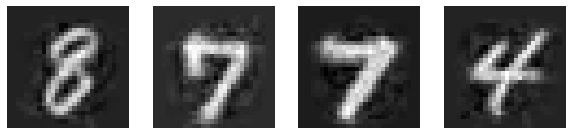

In [31]:
reshaped_images_omp = reconstructed_images[-4:].reshape(-1, imw, imw)

# Display the images using plt
fig, axs = plt.subplots(1, 4, figsize=(10, 5))
for i in range(4):
    axs[i].imshow(reshaped_images_omp[i], cmap='gray')
    axs[i].axis('off')
plt.show()

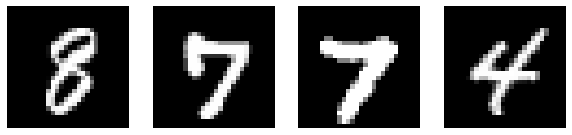

In [32]:
#Test Images
reshaped_images_test = images_test[-4:].reshape(-1, imw, imw)

# Display the images using plt
fig, axs = plt.subplots(1, 4, figsize=(10, 5))
for i in range(4):
    axs[i].imshow(reshaped_images_test[i], cmap='gray')
    axs[i].axis('off')
plt.show()

# NMP


In [33]:
dictionary.shape

(2352, 784)

In [34]:

class OMPEnvironment(gym.Env):
    """
    A Reinforcement Learning environment that implements Orthogonal Matching Pursuit (OMP) algorithm for sparse coding.
    
    Attributes:
        dictionary (np.array): The dictionary matrix for sparse coding.
        image (np.array): The input image data to be reconstructed.
        num_atoms (int): The number of atoms in the dictionary.
        observation_space (gym.spaces.Box): The observation space representing the selected atoms.
        action_space (gym.spaces.Discrete): The action space (0 for OMP, 1 for alternative strategy).
        residual (np.array): The current residual of the input image.
        selected_indices (list): The indices of the selected atoms from the dictionary.
        approximated_signals (list): The list of approximated signals at each step.
    """
    def __init__(self, dictionary, yFull, non_zero_coeff=None):
        self.dictionary = dictionary.T
        self.yFull = yFull
        self.i = -1 #set to -1 because we call reset() at the end of __init__ and this adds 1 to i
        self.y = yFull[self.i] #will be set to first image after reset()
        self.num_atoms = dictionary.shape[0]
        self.num_feats = dictionary.shape[1]
        self.action_space = spaces.Discrete(2)
        self.residual = self.y.copy() #will also be set to first image after reset()
        self.approximated_signals = []
        self.decisions = []
        if non_zero_coeff is None:
            self.non_zero_coeff = int(self.num_feats/10)
        else:
            self.non_zero_coeff = non_zero_coeff

        # Define the low and high bounds of each observation component
        # Residual Norm can theoretically go up to infinity, but we set a reasonable upper bound based on the input data
        residual_norm_bounds = (0, np.linalg.norm(self.y))
        # Determinant of the Gram Matrix can range from 0 to potentially a large number, but depends on the dictionary
        det_gram_matrix_bounds = (0, np.inf)
        # Mutual coherence ranges between 0 (no coherence) and 1 (perfect coherence)
        mutual_coherence_bounds = (0, 1)
        # Progress is step number divided by the maximum number of steps/non-zero coefficients
        progress_bounds = (0, 1)

        # Observation space now consists of the four components defined above
        self.observation_space = spaces.Box(
            low=np.array([residual_norm_bounds[0], det_gram_matrix_bounds[0], mutual_coherence_bounds[0], mutual_coherence_bounds[0], progress_bounds[0]]),
            high=np.array([residual_norm_bounds[1], det_gram_matrix_bounds[1], mutual_coherence_bounds[1], mutual_coherence_bounds[1], progress_bounds[1]]),
            dtype=np.float32
        )
        self.seed()
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def reset(self):
        self.i = (self.i + 1) % self.yFull.shape[0]
        self.y = self.yFull[self.i] 
        self.residual = self.y.copy()
        self.selected_indices = []
        ob = self.get_obs()
        return ob
    
    def get_obs(self):
        # 1) Residual Norm
        residual_norm = np.linalg.norm(self.residual)/np.linalg.norm(self.y)

        # 2) Determinant of the Gram Matrix for already selected atoms
        if self.selected_indices:
            selected_atoms = self.dictionary[:, self.selected_indices]
            gram_matrix = np.dot(selected_atoms.T, selected_atoms)
            det_gram_matrix = np.linalg.det(gram_matrix)
        else:
            det_gram_matrix = 0  # Placeholder when no atoms are selected

        # 3) Mutual coherence of the selected atoms
        if self.selected_indices:
            normalized_gram_matrix = gram_matrix / np.outer(
                np.linalg.norm(selected_atoms, axis=0),
                np.linalg.norm(selected_atoms, axis=0)
            )
            mutual_coherence_selected = np.max(np.abs(normalized_gram_matrix - np.eye(len(self.selected_indices))))
        else:
            mutual_coherence_selected = 0  # Placeholder when no atoms are selected

        # 4) Mutual coherence of the unselected atoms
        if len(self.selected_indices) < self.num_atoms:
            unselected_atoms = self.dictionary[:, [i for i in range(self.num_atoms) if i not in self.selected_indices]]
            unselected_gram_matrix = np.dot(unselected_atoms.T, unselected_atoms)
            normalized_unselected_gram_matrix = unselected_gram_matrix / np.outer(
                np.linalg.norm(unselected_atoms, axis=0),
                np.linalg.norm(unselected_atoms, axis=0)
            )
            mutual_coherence_unselected = np.max(np.abs(normalized_unselected_gram_matrix - np.eye(unselected_atoms.shape[1])))
        else:
            mutual_coherence_unselected = 0  # Placeholder when no atoms are left to select

        # Concatenate all observations into a single numpy array ,
        c =  np.array([
            residual_norm,
            det_gram_matrix,
            mutual_coherence_selected,
            mutual_coherence_unselected,
            len(self.selected_indices) / self.non_zero_coeff
        ])

        # print(c.shape)
        return c
    
    def step(self, action):

        # action = 0 # uncomment this to have algo mimic OMP
        self.decisions.append(action)

        if action == 0 or not self.selected_indices:  # OMP action or first atom selection
            correlations = np.abs(np.dot(self.dictionary.T, self.residual))
            for index in self.selected_indices:
                correlations[index] = 0  # Zero out already selected atoms
            selected_atom_index = np.argmax(correlations)
            self.selected_indices.append(selected_atom_index)

            # Create sub-dictionary with selected atoms
            selected_atoms = self.dictionary[:, self.selected_indices]

        elif action == 1:  # New decision strategy
            # Find the atom least correlated with the selected atoms
            selected_atoms = self.dictionary[:, self.selected_indices]
            correlations = np.abs(selected_atoms.T @ self.dictionary)
            avg_correlations = np.mean(correlations, axis=0)
            avg_correlations[self.selected_indices] = np.inf  # Exclude already selected
            selected_atom_index = np.argmin(avg_correlations)

            # Update selected indices
            self.selected_indices.append(selected_atom_index)
            selected_atoms = self.dictionary[:, self.selected_indices]

        # Solve the least squares problem to find the best coefficients
        coefficients, _, _, _ = np.linalg.lstsq(selected_atoms, self.y, rcond=None)
        # Reconstruct the signal using the coefficients from least squares
        approximated_signal = np.dot(selected_atoms, coefficients)

        # Update residual as the difference between the original signal and the approximated signal
        self.residual = self.y - approximated_signal

        # Add the approximated signal to the history
        # self.approximated_signals.append(approximated_signal) #uncomment to track signal every step

        # Check if the reconstruction is sufficiently accurate
        done = False #np.allclose(self.y, approximated_signal, atol=1e-3) #same tolerance as OMP

        if len(self.selected_indices) == self.non_zero_coeff:
            self.approximated_signals.append([approximated_signal, self.y]) 
            done = True

        # Calculate the reward as the negative norm of the residual
        reward = -(np.linalg.norm(self.residual)/np.linalg.norm(self.y))

        observation = self.get_obs() 

        return observation, reward, done, {}
    
env = OMPEnvironment(dictionary, images, non_zero_coeff=NZC)
    
def build_agent(envGym):
    """
    Builds a Deep Q-Network (DQN) agent for the given environment with a more complex model.

    Args:
        env (gym.Env): The environment for which the agent is built.

    Returns:
        DQNAgent: An instance of the DQN agent.
    """
    model = Sequential()
    # Adjust the input shape to match the observation space of the environment
    model.add(Flatten(input_shape=(1,) + envGym.observation_space.shape))
    model.add(Dense(128, activation='tanh'))
    model.add(Dense(128, activation='tanh'))
    model.add(Dense(64, activation='tanh'))
    model.add(Dense(envGym.action_space.n, activation='relu'))

    memory = SequentialMemory(limit=20000, window_length=1)
    policy = BoltzmannQPolicy(tau=2.0)
    # policy = EpsGreedyQPolicy(eps=0.15)

    dqn = DQNAgent(model=model, 
                   nb_actions=envGym.action_space.n, 
                   memory=memory, 
                   nb_steps_warmup=100,
                   target_model_update=envGym.non_zero_coeff, 
                   gamma = .9,
                   policy=policy)

    dqn.compile(SGD(learning_rate=1e-4), metrics=['mae'])

    return dqn

# Assume 'dictionary' and 'images' are defined and initialized elsewhere in the code

agent = build_agent(env)
agent.fit(env, nb_steps=2*env.non_zero_coeff*len(images), visualize=False, verbose=3)


Training for 76800 steps ...


C:\Users\Fin Amin\AppData\Roaming\Python\Python39\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


    32/76800: episode: 1, duration: 5.822s, episode steps:  32, steps per second:   5, episode reward: -9.731, mean reward: -0.304 [-0.510, -0.227], mean action: 0.469 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    64/76800: episode: 2, duration: 4.707s, episode steps:  32, steps per second:   7, episode reward: -11.154, mean reward: -0.349 [-0.461, -0.263], mean action: 0.625 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    96/76800: episode: 3, duration: 4.764s, episode steps:  32, steps per second:   7, episode reward: -10.438, mean reward: -0.326 [-0.536, -0.260], mean action: 0.531 [0.000, 1.000],  loss: --, mae: --, mean_q: --


C:\Users\Fin Amin\AppData\Roaming\Python\Python39\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


   128/76800: episode: 4, duration: 5.230s, episode steps:  32, steps per second:   6, episode reward: -8.361, mean reward: -0.261 [-0.524, -0.163], mean action: 0.562 [0.000, 1.000],  loss: 0.056384, mae: 0.266571, mean_q: 0.511300
   160/76800: episode: 5, duration: 5.046s, episode steps:  32, steps per second:   6, episode reward: -10.523, mean reward: -0.329 [-0.448, -0.279], mean action: 0.531 [0.000, 1.000],  loss: 0.048267, mae: 0.260160, mean_q: 0.499165
   192/76800: episode: 6, duration: 4.945s, episode steps:  32, steps per second:   6, episode reward: -9.829, mean reward: -0.307 [-0.565, -0.234], mean action: 0.594 [0.000, 1.000],  loss: 0.052483, mae: 0.254254, mean_q: 0.488452
   224/76800: episode: 7, duration: 4.956s, episode steps:  32, steps per second:   6, episode reward: -10.125, mean reward: -0.316 [-0.488, -0.235], mean action: 0.625 [0.000, 1.000],  loss: 0.051429, mae: 0.252238, mean_q: 0.471863
   256/76800: episode: 8, duration: 4.758s, episode steps:  32, st

In [ ]:
len(images)

1200

In [ ]:
len(env.approximated_signals)


194

In [ ]:
ap = np.array(env.approximated_signals)[:,0]
y = np.array(env.approximated_signals)[:,1]
ap.shape

(194, 784)

In [ ]:
# from keras.utils.vis_utils import plot_model

# plot_model(agent.model, to_file='agent_network.png', show_shapes=True, show_layer_names=True)


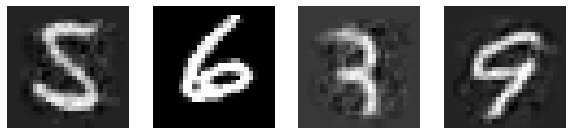

In [ ]:


# Reshape the last 4 images to 8 by 8
reshaped_images = ap[-4:].reshape(-1, imw, imw)

# Display the images using plt
fig, axs = plt.subplots(1, 4, figsize=(10, 5))
for i in range(4):
    axs[i].imshow(reshaped_images[i], cmap='gray')
    axs[i].axis('off')
plt.show()


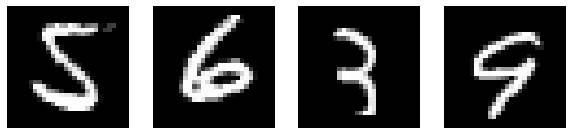

In [ ]:
reshaped_images = y[-4:].reshape(-1, imw, imw)

# Display the images using plt
fig, axs = plt.subplots(1, 4, figsize=(10, 5))
for i in range(4):
    axs[i].imshow(reshaped_images[i], cmap='gray')
    axs[i].axis('off')
plt.show()

In [ ]:
avg_ssim_value = average_ssim(y, ap)
print(f"Average SSIM: {avg_ssim_value}")

avg_mae_value = average_mae(y, ap)
print(f"Average MAE: {avg_mae_value}")

avg_2norm = average_2norm(y, ap)
print(f"Average 2-norm: {avg_2norm}")

Average SSIM: 0.9779983634932323
Average MAE: 0.04276142275620531
Average 2-norm: 2.055645166786223


In [ ]:
images.shape

(898, 64)

In [ ]:
env.observation_space.shape

(5,)

# Test NMP

In [ ]:
TestEnv = OMPEnvironment(dictionary, images_test, non_zero_coeff=NZC)
agent.test_policy = GreedyQPolicy()


In [ ]:
agent.test(TestEnv, nb_episodes=len(images_test), visualize=False, verbose = 2)


Testing for 200 episodes ...
Episode 1: reward: -6.245, steps: 32
Episode 2: reward: -10.919, steps: 32
Episode 3: reward: -11.990, steps: 32
Episode 4: reward: -9.071, steps: 32
Episode 5: reward: -10.186, steps: 32
Episode 6: reward: -9.207, steps: 32
Episode 7: reward: -9.855, steps: 32
Episode 8: reward: -12.078, steps: 32
Episode 9: reward: -10.058, steps: 32
Episode 10: reward: -11.371, steps: 32
Episode 11: reward: -15.506, steps: 32
Episode 12: reward: -9.538, steps: 32
Episode 13: reward: -9.381, steps: 32
Episode 14: reward: -8.003, steps: 32
Episode 15: reward: -13.231, steps: 32
Episode 16: reward: -9.918, steps: 32
Episode 17: reward: -8.063, steps: 32
Episode 18: reward: -9.858, steps: 32
Episode 19: reward: -13.668, steps: 32
Episode 20: reward: -10.926, steps: 32
Episode 21: reward: -11.846, steps: 32
Episode 22: reward: -6.595, steps: 32
Episode 23: reward: -10.228, steps: 32
Episode 24: reward: -6.898, steps: 32
Episode 25: reward: -10.457, steps: 32
Episode 26: rewar

In [ ]:
apTest = np.array(TestEnv.approximated_signals)[:,0]
yTest = np.array(TestEnv.approximated_signals)[:,1]

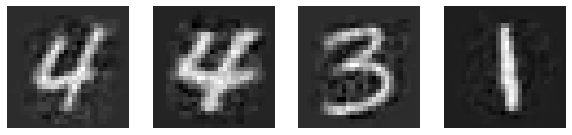

In [ ]:
# Reshape the last 4 images to 8 by 8
reshaped_images = apTest[-4:].reshape(-1, imw, imw)

# Display the images using plt
fig, axs = plt.subplots(1, 4, figsize=(10, 5))
for i in range(4):
    axs[i].imshow(reshaped_images[i], cmap='gray')
    axs[i].axis('off')
plt.show()

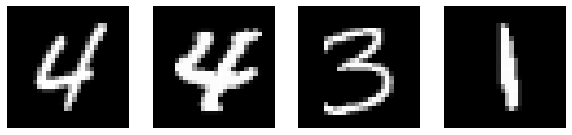

In [ ]:
reshaped_images = yTest[-4:].reshape(-1, imw, imw)

# Display the images using plt
fig, axs = plt.subplots(1, 4, figsize=(10, 5))
for i in range(4):
    axs[i].imshow(reshaped_images[i], cmap='gray')
    axs[i].axis('off')
plt.show()

In [ ]:

avg_ssim_value = average_ssim(yTest, apTest)
print(f"Average SSIM: {avg_ssim_value}")

avg_mae_value = average_mae(yTest, apTest)
print(f"Average MAE: {avg_mae_value}")

avg_2norm = average_2norm(yTest, apTest)
print(f"Average 2-norm: {avg_2norm}")

Average SSIM: 0.9717859634756553
Average MAE: 0.0514582868155225
Average 2-norm: 2.447796787670697


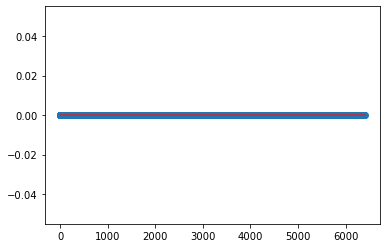

In [ ]:
plt.stem(TestEnv.decisions);    

In [ ]:
np.sum(TestEnv.decisions)

0

In [ ]:
np.mean(TestEnv.decisions), np.std(TestEnv.decisions)

(0.0010080645161290322, 0.031734024674792735)

In [ ]:
#eps greedy .25
# Average SSIM: 0.9795328173117814
# Average MAE: 0.777859251963805
# Average 2-norm: 8.802577894730895

# Full Loop

In [35]:

# Load the dataset and dictionary
#to use Sk 'digits' dataset, uncomment the following lines

digits = load_digits()
im = digits.data
im = im/16.0
images = im[ 0:(len(im)//2)] # Use the first half of the dataset for training
images_test = im[(len(im)//2):] # Use the second half of the dataset for testing

#to use MNIST dataset, uncomment the following lines

# rng = np.random.default_rng()

# (images, _), (images_test, _) = tf.keras.datasets.mnist.load_data()
# images = images.reshape(images.shape[0], -1)
# rng.shuffle(images)
# images = images[:len(images)//50]/(255.0)

# images_test = images_test.reshape(images_test.shape[0], -1)
# rng.shuffle(images_test)
# images_test = images_test[:len(images_test)//50]/(255.0)


imw = int(np.sqrt(images.shape[1]))

In [36]:
images.shape

(898, 64)

In [37]:
def exp1(images = images, images_test = images_test, ms = [4, 8, 16, 24, 32, 48, 56]):
    results_nmp = []
    results_omp = []
    for m in tqdm(ms):
        print(f"Running for m = {m}")
        dictionary, dict_learner = learn_dictionary_from_digits(images)
        env = OMPEnvironment(dictionary, images, non_zero_coeff=m)
        agent = build_agent(env)
        agent.fit(env, nb_steps=2*m*len(images), visualize=False, verbose=0)
        TestEnv = OMPEnvironment(dictionary, images_test, non_zero_coeff=m)
        agent.test_policy = GreedyQPolicy()
        agent.test(TestEnv, nb_episodes=len(images_test), visualize=False, verbose = 0)
        apTest = np.array(TestEnv.approximated_signals)[:,0]
        yTest = np.array(TestEnv.approximated_signals)[:,1]
        avg_ssim_value = average_ssim(yTest, apTest)
        avg_mae_value = average_mae(yTest, apTest)
        avg_2norm = average_2norm(yTest, apTest)
        max_ae = max_absolute_error(yTest, apTest)
        min_ae = min_absolute_error(yTest, apTest)
        results_nmp.append([m, avg_ssim_value, avg_mae_value, avg_2norm, max_ae, min_ae])
        print("RL dec mean and std", np.mean(TestEnv.decisions), np.std(TestEnv.decisions))

        # Reconstruct the dataset using OMP
        reconstructed_images = reconstruct_with_OMP(dictionary, images_test, m)
        # Evaluate the average SSIM
        avg_ssim_value_omp = average_ssim(images_test, reconstructed_images)
        avg_mae_value_omp = average_mae(images_test, reconstructed_images)
        average_2_norm_omp = average_2norm(images_test, reconstructed_images)
        max_ae_omp = max_absolute_error(images_test, reconstructed_images)
        min_ae_omp = min_absolute_error(images_test, reconstructed_images)
        results_omp.append([m, avg_ssim_value_omp, avg_mae_value_omp, average_2_norm_omp, max_ae_omp, min_ae_omp])


    return np.array(results_nmp), np.array(results_omp)

In [38]:
exp1_nmp, exp1_omp = exp1()

  0%|          | 0/7 [00:00<?, ?it/s]

Running for m = 4


C:\Users\Fin Amin\AppData\Roaming\Python\Python39\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


RL dec mean and std 0.0 0.0


 14%|█▍        | 1/7 [01:45<10:32, 105.38s/it]

Running for m = 8


C:\Users\Fin Amin\AppData\Roaming\Python\Python39\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


RL dec mean and std 0.017658509454949945 0.13170682024397745


 29%|██▊       | 2/7 [04:55<12:54, 154.98s/it]

Running for m = 16


C:\Users\Fin Amin\AppData\Roaming\Python\Python39\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


RL dec mean and std 6.952169076751947e-05 0.008337676984750145


 43%|████▎     | 3/7 [10:22<15:35, 233.85s/it]

Running for m = 24


C:\Users\Fin Amin\AppData\Roaming\Python\Python39\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


RL dec mean and std 0.0001853911753800519 0.013614580621236305


 57%|█████▋    | 4/7 [17:55<16:00, 320.21s/it]

Running for m = 32


C:\Users\Fin Amin\AppData\Roaming\Python\Python39\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


RL dec mean and std 0.0014947163515016686 0.03863265684016855


 71%|███████▏  | 5/7 [27:14<13:33, 406.52s/it]

Running for m = 48


C:\Users\Fin Amin\AppData\Roaming\Python\Python39\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


RL dec mean and std 0.0 0.0


 86%|████████▌ | 6/7 [42:23<09:37, 577.21s/it]

Running for m = 56


C:\Users\Fin Amin\AppData\Roaming\Python\Python39\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


RL dec mean and std 0.0 0.0


100%|██████████| 7/7 [1:05:44<00:00, 563.44s/it]


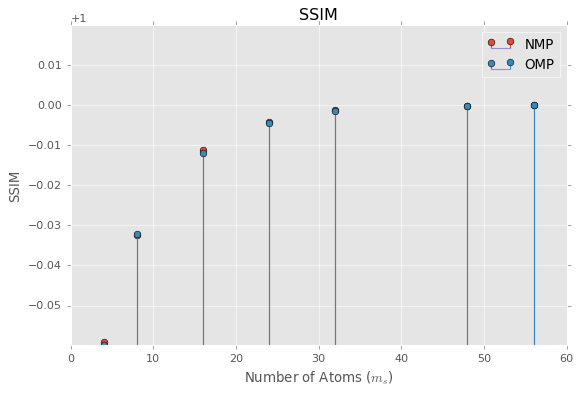

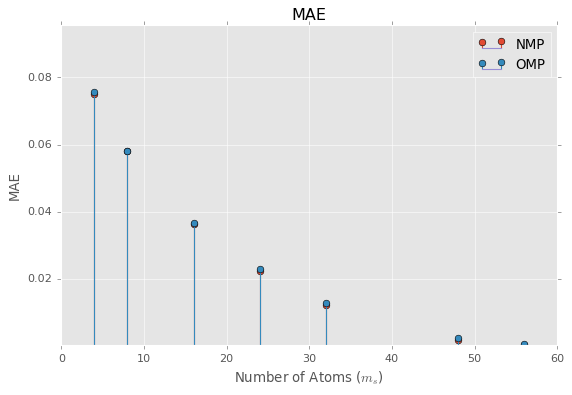

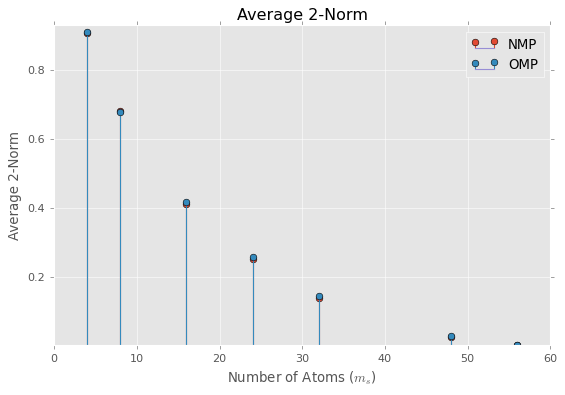

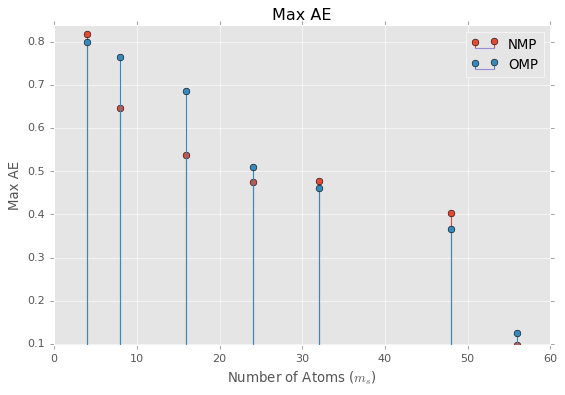

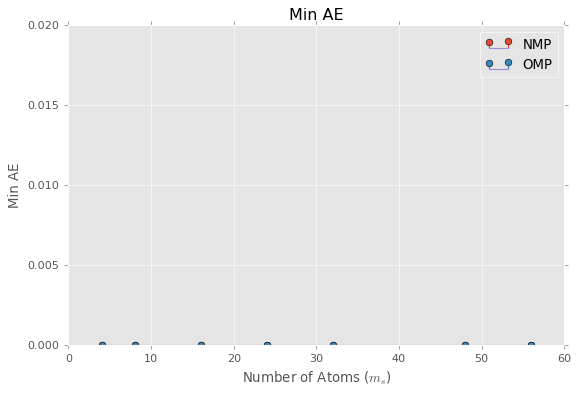

In [124]:
# Extract metrics for plotting
metrics_nmp = exp1_nmp[:, 1:]  # Assuming columns 2 to 5 are metrics (skip SSIM column)
metrics_omp = exp1_omp[:, 1:]  # Assuming columns 2 to 5 are metrics (skip SSIM column)
metric_labels = ["SSIM","MAE", "Average 2-Norm", "Max AE", "Min AE"]
ms = exp1_nmp[:, 0]  # Assuming column 0 is m
# Plotting each metric on a separate plot
for i in range(len(metric_labels)):
    plt.figure(figsize=(8, 5))
    plt.stem(ms, metrics_nmp[:, i], linefmt='C0-', markerfmt='C0o', label='NMP')
    plt.stem(ms, metrics_omp[:, i], linefmt='C1-', markerfmt='C1o', label='OMP')
    plt.ylim([np.min(np.vstack((metrics_nmp[:, i], metrics_omp[:, i]))),
              np.max(np.vstack((metrics_nmp[:, i], metrics_omp[:, i]))) + 0.02])
    plt.title(metric_labels[i])
    plt.xlabel("Number of Atoms ($m_s$)")
    plt.ylabel(metric_labels[i])
    plt.legend()
    plt.show()

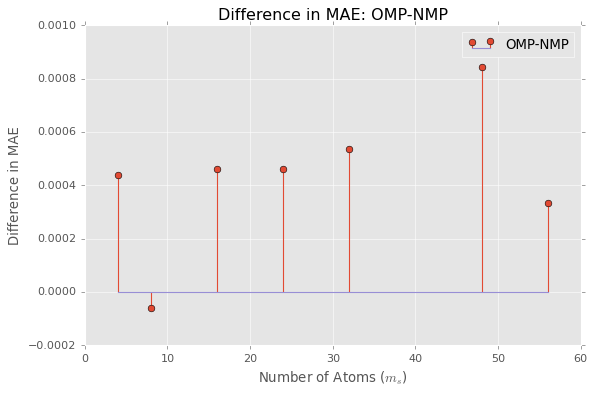

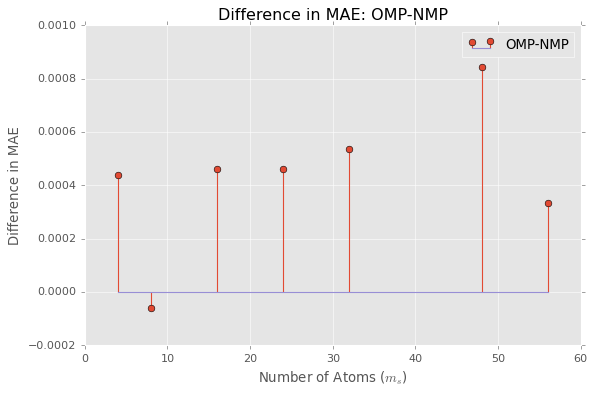

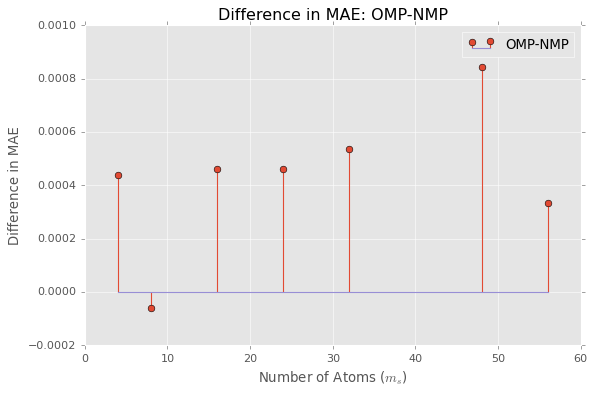

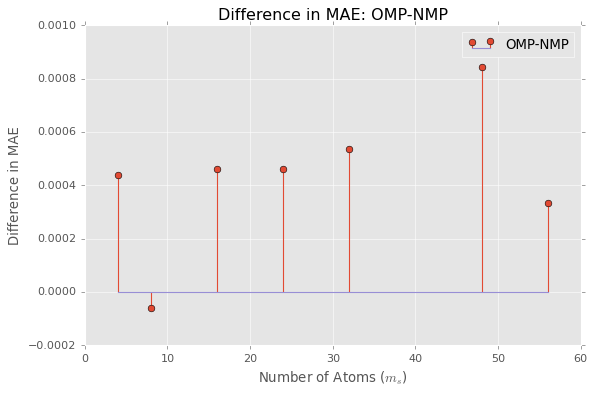

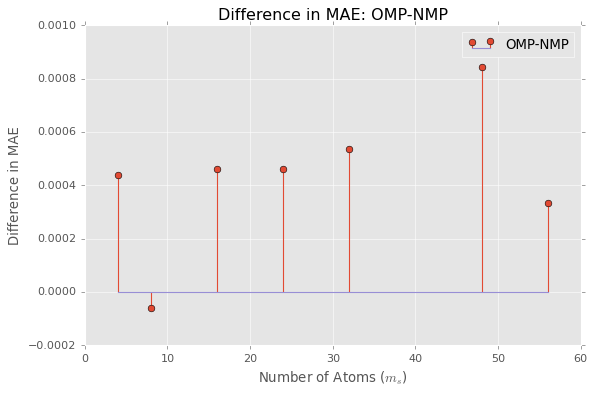

In [123]:
# Extract metrics for plotting
metrics_nmp = exp1_nmp[:, 1:]  # Assuming columns 2 to 5 are metrics (skip SSIM column)
metrics_omp = exp1_omp[:, 1:]  # Assuming columns 2 to 5 are metrics (skip SSIM column)
metric_labels = ["SSIM","Difference in MAE", "Difference in Average 2-Norm", "Max AE", "Min AE"]
ms = exp1_nmp[:, 0]  # Assuming column 0 is m
# Plotting each metric on a separate plot
for i in range(len(metric_labels)):
    i = 1
    plt.figure(figsize=(8, 5))
    plt.stem(ms, -metrics_nmp[:, i]+metrics_omp[:, i], linefmt='C0-', markerfmt='C0o', label='OMP-NMP')
    plt.ylim()
    plt.title("Difference in MAE: OMP-NMP")
    plt.xlabel("Number of Atoms ($m_s$)")
    plt.ylabel(metric_labels[i])
    plt.legend()
    plt.show()

In [ ]:
metrics_nmp.T[1]

array([0.07561147, 0.05761232, 0.03600627, 0.02146181, 0.01143686])

In [ ]:
metrics_omp.T[1]

array([0.07537284, 0.05733443, 0.03576737, 0.02157161, 0.0117419 ])

In [41]:
def add_noise(images, sigma):
    """Add Gaussian noise to each image in the dataset."""
    noisy_images = []
    for image in images:
        noise = np.random.normal(0, sigma, image.shape)
        noisy_image = image + noise
        noisy_images.append(noisy_image)
    return np.array(noisy_images)

In [108]:
def exp2(images_train = images, images_test = images_test, sigmas =  [0.5, 1, 2, 4, 8, 16, 32, 40]):
    results_nmp = []
    results_omp = []
    m = 8
    for sigma in tqdm(sigmas):
        noisy_images_train = add_noise(images_train, sigma)

        print(f"Running for sigma = {sigma}, m = {m}")
        dictionary, _ = learn_dictionary_from_digits(noisy_images_train)
        env = OMPEnvironment(dictionary, noisy_images_train, non_zero_coeff=m)
        agent = build_agent(env)
        agent.fit(env, nb_steps=2*m*len(noisy_images_train), visualize=False, verbose=0)
        TestEnv = OMPEnvironment(dictionary, images_test, non_zero_coeff=m)
        agent.test_policy = GreedyQPolicy()
        agent.test(TestEnv, nb_episodes=len(images_test), visualize=False, verbose=0)
        apTest = np.array(TestEnv.approximated_signals)[:,0]
        yTest = np.array(TestEnv.approximated_signals)[:,1]
        avg_ssim_value = average_ssim(yTest, apTest)
        avg_mae_value = average_mae(yTest, apTest)
        avg_2norm = average_2norm(yTest, apTest)
        max_ae = max_absolute_error(yTest, apTest)
        min_ae = min_absolute_error(yTest, apTest)
        results_nmp.append([sigma, avg_ssim_value, avg_mae_value, avg_2norm, max_ae, min_ae])
        print("RL dec mean and std", np.mean(TestEnv.decisions), np.std(TestEnv.decisions))

        # Reconstruct the dataset using OMP
        reconstructed_images = reconstruct_with_OMP(dictionary, images_test, m)
        avg_ssim_value_omp = average_ssim(images_test, reconstructed_images)
        avg_mae_value_omp = average_mae(images_test, reconstructed_images)
        average_2_norm_omp = average_2norm(images_test, reconstructed_images)
        min_ae_omp = min_absolute_error(images_test, reconstructed_images)
        max_ae_omp = max_absolute_error(images_test, reconstructed_images)
        results_omp.append([sigma, avg_ssim_value_omp, avg_mae_value_omp, average_2_norm_omp, max_ae_omp, min_ae_omp])

    return np.array(results_nmp), np.array(results_omp)

In [109]:
exp2_nmp, exp2_omp = exp2()

  0%|          | 0/8 [00:00<?, ?it/s]

Running for sigma = 0.5, m = 8


C:\Users\Fin Amin\AppData\Roaming\Python\Python39\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


RL dec mean and std 0.0015294771968854283 0.03907861175105425


 12%|█▎        | 1/8 [04:51<34:03, 291.92s/it]

Running for sigma = 1, m = 8


C:\Users\Fin Amin\AppData\Roaming\Python\Python39\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


RL dec mean and std 0.0 0.0


 25%|██▌       | 2/8 [10:07<30:35, 305.97s/it]

Running for sigma = 2, m = 8


C:\Users\Fin Amin\AppData\Roaming\Python\Python39\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


RL dec mean and std 0.0 0.0


 38%|███▊      | 3/8 [15:27<26:02, 312.47s/it]

Running for sigma = 4, m = 8


C:\Users\Fin Amin\AppData\Roaming\Python\Python39\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


RL dec mean and std 0.0 0.0


 50%|█████     | 4/8 [21:04<21:28, 322.14s/it]

Running for sigma = 8, m = 8


C:\Users\Fin Amin\AppData\Roaming\Python\Python39\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


RL dec mean and std 0.0 0.0


 62%|██████▎   | 5/8 [26:37<16:18, 326.07s/it]

Running for sigma = 16, m = 8


C:\Users\Fin Amin\AppData\Roaming\Python\Python39\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


RL dec mean and std 0.0 0.0


 75%|███████▌  | 6/8 [32:36<11:14, 337.01s/it]

Running for sigma = 32, m = 8


C:\Users\Fin Amin\AppData\Roaming\Python\Python39\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


RL dec mean and std 0.0 0.0


 88%|████████▊ | 7/8 [38:45<05:47, 347.55s/it]

Running for sigma = 40, m = 8


C:\Users\Fin Amin\AppData\Roaming\Python\Python39\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


RL dec mean and std 0.0 0.0


100%|██████████| 8/8 [44:44<00:00, 335.54s/it]


In [110]:
exp2_omp

array([[5.00000000e-01, 9.27196648e-01, 1.09478019e-01, 1.10059682e+00,
        7.33793724e-01, 0.00000000e+00],
       [1.00000000e+00, 8.57955031e-01, 1.54222320e-01, 1.54625133e+00,
        8.48370956e-01, 0.00000000e+00],
       [2.00000000e+00, 7.80105170e-01, 1.80169096e-01, 1.81130610e+00,
        1.16561351e+00, 0.00000000e+00],
       [4.00000000e+00, 6.43655213e-01, 2.12895681e-01, 2.11587025e+00,
        1.22672542e+00, 0.00000000e+00],
       [8.00000000e+00, 6.44403017e-01, 2.18899978e-01, 2.15358441e+00,
        1.37337733e+00, 0.00000000e+00],
       [1.60000000e+01, 2.77416336e-01, 3.11680843e-01, 2.91508164e+00,
        1.63603475e+00, 0.00000000e+00],
       [3.20000000e+01, 4.08436120e-01, 2.83738891e-01, 2.69989733e+00,
        1.52279563e+00, 0.00000000e+00],
       [4.00000000e+01, 2.14147205e-01, 3.37625951e-01, 3.16058454e+00,
        1.73859390e+00, 3.32975424e-06]])

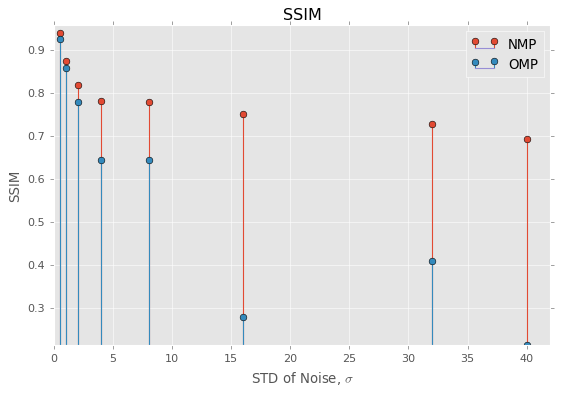

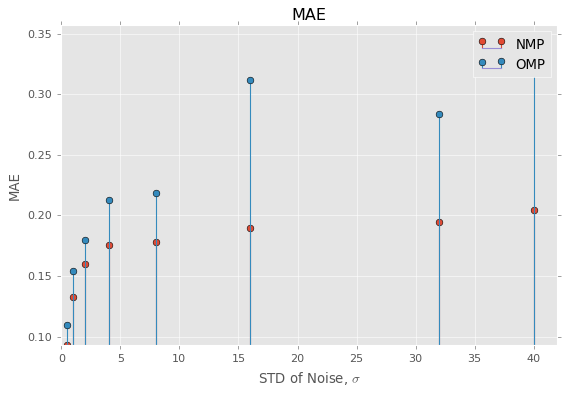

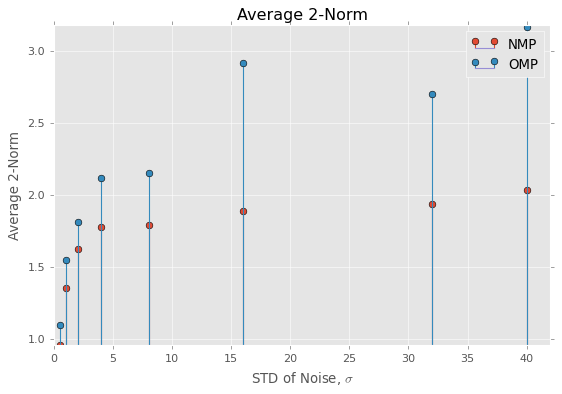

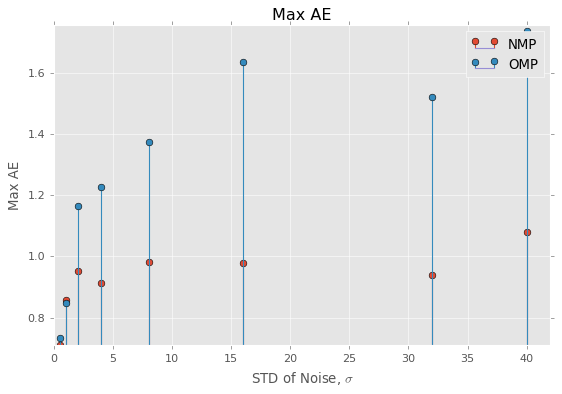

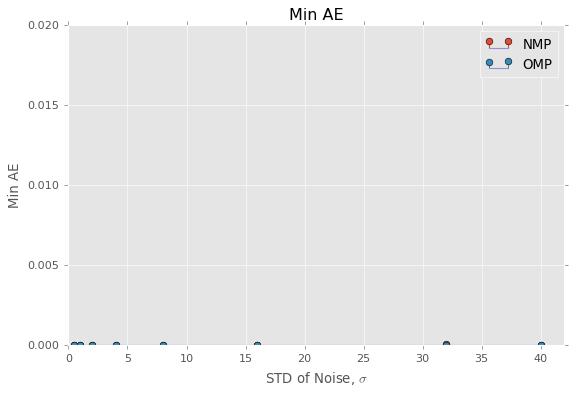

In [125]:
# Extract metrics for plotting
metrics_nmp2 = exp2_nmp[:, 1:]  # Assuming columns 1 to 5 are metrics 
metrics_omp2 = exp2_omp[:, 1:]  # Assuming columns 1 to 5 are metrics 
metric_labels = ["SSIM","MAE", "Average 2-Norm","Max AE", "Min AE"]
ms = exp2_nmp[:, 0]  # Assuming column 0 is m
# Plotting each metric on a separate plot
for i in range(len(metric_labels)):
    plt.figure(figsize=(8, 5))
    plt.stem(ms, metrics_nmp2[:, i], linefmt='C0-', markerfmt='C0o', label='NMP')
    plt.stem(ms, metrics_omp2[:, i], linefmt='C1-', markerfmt='C1o', label='OMP')
    plt.ylim([np.min(np.vstack((metrics_nmp2[:, i], metrics_omp2[:, i]))) ,
              np.max(np.vstack((metrics_nmp2[:, i], metrics_omp2[:, i]))) + 0.02])
    plt.xlim([0, 42])
    plt.title(metric_labels[i])
    plt.xlabel("STD of Noise, $\sigma$")
    plt.ylabel(metric_labels[i])
    plt.legend()
    plt.show()

# WTF?


In [92]:
images_train = images
sigma = 8
m = 8
noisy_images_train = add_noise(images_train, sigma)

print(f"Running for sigma = {sigma}, m = {m}")
Noise_dictionary, _ = learn_dictionary_from_digits(noisy_images_train)

Running for sigma = 8, m = 8


In [93]:
reconstructed_images = reconstruct_with_OMP(Noise_dictionary, images_test, m)
avg_ssim_value_omp = average_ssim(images_test, reconstructed_images)
avg_mae_value_omp = average_mae(images_test, reconstructed_images)
average_2_norm_omp = average_2norm(images_test, reconstructed_images)
min_ae_omp = min_absolute_error(images_test, reconstructed_images)
max_ae_omp = max_absolute_error(images_test, reconstructed_images)
print(f"Average SSIM: {avg_ssim_value_omp}")
print(f"Average MAE: {avg_mae_value_omp}")
print(f"Average 2-norm: {average_2_norm_omp}")
print(f"Max absolute error: {max_ae_omp}")
print(f"Min absolute error: {min_ae_omp}")

Average SSIM: 0.5066247522646469
Average MAE: 0.2586862339163819
Average 2-norm: 2.4794434830889367
Max absolute error: 1.4454681544747183
Min absolute error: 0.0


In [53]:
env = OMPEnvironment(Noise_dictionary, noisy_images_train, non_zero_coeff=m)
agent = build_agent(env)
agent.fit(env, nb_steps=2*m*len(noisy_images_train), visualize=False, verbose=3)


Training for 14368 steps ...


C:\Users\Fin Amin\AppData\Roaming\Python\Python39\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


     8/14368: episode: 1, duration: 0.396s, episode steps:   8, steps per second:  20, episode reward: -5.980, mean reward: -0.747 [-0.883, -0.575], mean action: 0.375 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    16/14368: episode: 2, duration: 0.031s, episode steps:   8, steps per second: 256, episode reward: -7.108, mean reward: -0.888 [-0.947, -0.817], mean action: 0.750 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    24/14368: episode: 3, duration: 0.025s, episode steps:   8, steps per second: 315, episode reward: -5.955, mean reward: -0.744 [-0.856, -0.667], mean action: 0.625 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    32/14368: episode: 4, duration: 0.024s, episode steps:   8, steps per second: 333, episode reward: -6.951, mean reward: -0.869 [-0.941, -0.742], mean action: 0.500 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    40/14368: episode: 5, duration: 0.026s, episode steps:   8, steps per second: 313, episode reward: -6.730, mean reward: -0.841 [-0.937, 

C:\Users\Fin Amin\AppData\Roaming\Python\Python39\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


   104/14368: episode: 13, duration: 1.337s, episode steps:   8, steps per second:   6, episode reward: -6.452, mean reward: -0.806 [-0.920, -0.710], mean action: 0.500 [0.000, 1.000],  loss: 0.275532, mae: 0.397584, mean_q: 0.103290
   112/14368: episode: 14, duration: 0.108s, episode steps:   8, steps per second:  74, episode reward: -6.596, mean reward: -0.825 [-0.930, -0.749], mean action: 0.625 [0.000, 1.000],  loss: 0.269647, mae: 0.397674, mean_q: 0.102962
   120/14368: episode: 15, duration: 0.113s, episode steps:   8, steps per second:  71, episode reward: -6.229, mean reward: -0.779 [-0.944, -0.719], mean action: 0.500 [0.000, 1.000],  loss: 0.286916, mae: 0.406441, mean_q: 0.107250
   128/14368: episode: 16, duration: 0.152s, episode steps:   8, steps per second:  53, episode reward: -6.528, mean reward: -0.816 [-0.923, -0.663], mean action: 0.250 [0.000, 1.000],  loss: 0.286484, mae: 0.401195, mean_q: 0.090943
   136/14368: episode: 17, duration: 0.118s, episode steps:   8,

In [54]:
TestEnv = OMPEnvironment(Noise_dictionary, images_test, non_zero_coeff=m)
agent.test_policy = GreedyQPolicy()

In [55]:
agent.test(TestEnv, nb_episodes=len(images_test), visualize=False, verbose = 2)

Testing for 899 episodes ...
Episode 1: reward: -4.920, steps: 8


Episode 2: reward: -4.878, steps: 8
Episode 3: reward: -4.629, steps: 8
Episode 4: reward: -4.707, steps: 8
Episode 5: reward: -5.014, steps: 8
Episode 6: reward: -4.961, steps: 8
Episode 7: reward: -4.956, steps: 8
Episode 8: reward: -4.807, steps: 8
Episode 9: reward: -4.823, steps: 8
Episode 10: reward: -5.177, steps: 8
Episode 11: reward: -5.006, steps: 8
Episode 12: reward: -4.931, steps: 8
Episode 13: reward: -4.778, steps: 8
Episode 14: reward: -5.260, steps: 8
Episode 15: reward: -4.778, steps: 8
Episode 16: reward: -5.038, steps: 8
Episode 17: reward: -4.899, steps: 8
Episode 18: reward: -4.735, steps: 8
Episode 19: reward: -5.053, steps: 8
Episode 20: reward: -5.200, steps: 8
Episode 21: reward: -5.202, steps: 8
Episode 22: reward: -4.710, steps: 8
Episode 23: reward: -4.964, steps: 8
Episode 24: reward: -5.060, steps: 8
Episode 25: reward: -5.071, steps: 8
Episode 26: reward: -4.893, steps: 8
Episode 27: reward: -4.664, steps: 8
Episode 28: reward: -4.761, steps: 8
Episode 2

In [56]:
apTest = np.array(TestEnv.approximated_signals)[:,0]
yTest = np.array(TestEnv.approximated_signals)[:,1]
avg_ssim_value_nmp = average_ssim(yTest, apTest)
avg_mae_value_nmp = average_mae(yTest, apTest)
avg_2norm_nmp = average_2norm(yTest, apTest)
max_ae_nmp = max_absolute_error(yTest, apTest)
min_ae_nmp = min_absolute_error(yTest, apTest)
print(f"Average SSIM: {avg_ssim_value_nmp}")
print(f"Average MAE: {avg_mae_value_nmp}")
print(f"Average 2-norm: {avg_2norm_nmp}")
print(f"Max absolute error: {max_ae_nmp}")
print(f"Min absolute error: {min_ae_nmp}")

Average SSIM: 0.7614285744117802
Average MAE: 0.184950441499746
Average 2-norm: 1.8545639766878796
Max absolute error: 0.9814525437144217
Min absolute error: 0.0


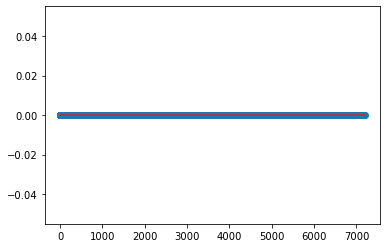

In [75]:
plt.stem(TestEnv.decisions);    

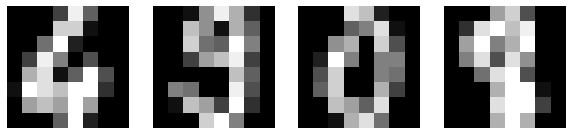

In [58]:
#Test Images
reshaped_images_test = images_test[2:6].reshape(-1, imw, imw)

# Display the images using plt
fig, axs = plt.subplots(1, 4, figsize=(10, 5))
for i in range(4):
    axs[i].imshow(reshaped_images_test[i], cmap='gray')
    axs[i].axis('off')
plt.show()


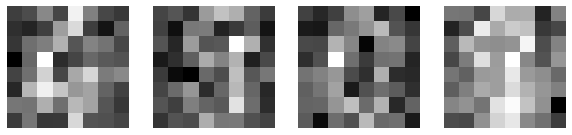

In [59]:

reshaped_images_omp = reconstructed_images[2:6].reshape(-1, imw, imw)

# Display the images using plt
fig, axs = plt.subplots(1, 4, figsize=(10, 5))
for i in range(4):
    axs[i].imshow(reshaped_images_omp[i], cmap='gray')
    axs[i].axis('off')
plt.show()



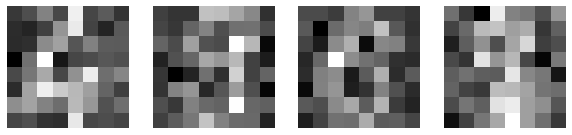

In [60]:
reshaped_images_NMP = apTest[1:5].reshape(-1, imw, imw)

# Display the images using plt
fig, axs = plt.subplots(1, 4, figsize=(10, 5))
for i in range(4):
    axs[i].imshow(reshaped_images_NMP[i], cmap='gray')
    axs[i].axis('off')
plt.show()

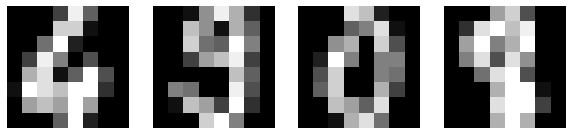

In [61]:
reshaped_images = yTest[1:5].reshape(-1, imw, imw)

# Display the images using plt
fig, axs = plt.subplots(1, 4, figsize=(10, 5))
for i in range(4):
    axs[i].imshow(reshaped_images[i], cmap='gray')
    axs[i].axis('off')
plt.show()

In [ ]:
noisy_images_train.dtype

dtype('float64')

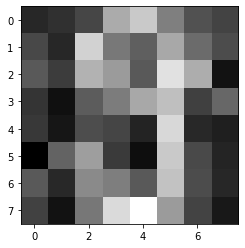

In [ ]:
plt.imshow(reshaped_images_NMP[1], cmap='gray')

In [69]:
apTest[0]

array([ 0.28568973,  0.35216863,  0.37163726,  0.62966809,  0.57507269,
        0.38909886,  0.25724419, -0.0245636 ,  0.05507858,  0.12162668,
        0.48398128,  0.53530771,  0.35055267,  0.15745765,  0.08306154,
        0.2494901 , -0.04531745,  0.18742357,  0.90671694,  0.25704299,
        0.74880574, -0.19466364, -0.15037738,  0.03807717,  0.19709093,
        0.44547703,  0.28439161,  0.8686539 ,  1.20525529,  0.5776188 ,
        0.19608817,  0.15352042,  0.05280772,  0.03677873,  1.00203301,
        0.13695558,  0.43220176,  0.85400104,  0.1788654 ,  0.44233312,
        0.16061186,  0.62483943,  1.03064881,  0.15566129,  0.20541503,
        0.56408521,  0.47007466,  0.07242871, -0.01491651, -0.00721877,
        0.64270186,  0.40149339,  0.57845381,  1.06628303,  0.05391237,
       -0.337671  ,  0.04195574,  0.40696124,  0.31433817,  0.29729818,
        0.86296786,  0.30794862,  0.08619236,  0.36342622])

In [72]:
images_test[2]

array([0.    , 0.    , 0.    , 0.25  , 0.9375, 0.375 , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.8125, 0.8125, 0.0625, 0.    , 0.    ,
       0.    , 0.    , 0.4375, 1.    , 0.125 , 0.    , 0.    , 0.    ,
       0.    , 0.25  , 0.9375, 0.5   , 0.    , 0.3125, 0.    , 0.    ,
       0.    , 0.6875, 0.875 , 0.0625, 0.375 , 1.    , 0.3125, 0.    ,
       0.0625, 1.    , 0.875 , 0.75  , 1.    , 1.    , 0.1875, 0.    ,
       0.    , 0.625 , 0.75  , 0.625 , 1.    , 0.625 , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.375 , 1.    , 0.125 , 0.    , 0.    ])

In [66]:
yTest[1]


array([0.    , 0.    , 0.    , 0.25  , 0.9375, 0.375 , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.8125, 0.8125, 0.0625, 0.    , 0.    ,
       0.    , 0.    , 0.4375, 1.    , 0.125 , 0.    , 0.    , 0.    ,
       0.    , 0.25  , 0.9375, 0.5   , 0.    , 0.3125, 0.    , 0.    ,
       0.    , 0.6875, 0.875 , 0.0625, 0.375 , 1.    , 0.3125, 0.    ,
       0.0625, 1.    , 0.875 , 0.75  , 1.    , 1.    , 0.1875, 0.    ,
       0.    , 0.625 , 0.75  , 0.625 , 1.    , 0.625 , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.375 , 1.    , 0.125 , 0.    , 0.    ])

In [63]:
reshaped_images_NMP[1]

array([[ 0.08523766,  0.01855893,  0.02114245,  0.76632425,  0.74534357,
         0.62148342,  0.46489034,  0.00590005],
       [ 0.11016169,  0.03751912,  0.27434643,  0.43818311,  0.16559643,
         0.33889603,  0.34566997,  0.1415235 ],
       [ 0.27255644,  0.14405622,  0.59285866,  0.1797519 ,  0.14169272,
         1.10036689,  0.71770723, -0.2135061 ],
       [-0.07768864,  0.17934029,  0.2829714 ,  0.63285442,  0.53871856,
         0.72090682,  0.08742925, -0.10910638],
       [ 0.03223367, -0.25885199, -0.07202045,  0.34021079, -0.00866446,
         0.85315344,  0.08822671,  0.27245002],
       [ 0.02597771,  0.44462111,  0.53263904, -0.04588264,  0.19778238,
         0.57364971,  0.16152695, -0.22603888],
       [ 0.16338148,  0.04108427,  0.42622432,  0.30750515,  0.27177068,
         1.09472263,  0.28841069,  0.2509533 ],
       [ 0.08104118,  0.23125232,  0.37532526,  0.78664121,  0.42629693,
         0.31031755,  0.30142185, -0.07215471]])

In [73]:
reshaped_images_omp[2]

array([[-0.2404958 , -0.37450922, -0.25031187,  0.13368142,  0.22125379,
        -0.39019879, -0.20244388, -0.57028382],
       [-0.43958323, -0.45186402, -0.05981891,  0.03062116,  0.1629076 ,
         0.35320935, -0.15700161, -0.30212596],
       [-0.20018959, -0.21462809,  0.32364488,  0.09494532, -0.54174601,
         0.08054065,  0.11270999, -0.23006585],
       [-0.33970042, -0.16523123,  0.69649219, -0.01939736, -0.27567287,
        -0.01453093,  0.        , -0.38554474],
       [ 0.00276817,  0.07496293,  0.17926367, -0.19709726, -0.33558569,
         0.29939881, -0.34272979, -0.36325423],
       [-0.09202722,  0.01218117,  0.23445859, -0.44084147, -0.16021838,
        -0.02461694, -0.11202538, -0.33579797],
       [-0.07453335, -0.06272176,  0.16947775,  0.37776026, -0.03626818,
         0.3132737 , -0.36776508, -0.08017353],
       [-0.11936572, -0.51742486, -0.02711688, -0.17312127,  0.3519222 ,
        -0.0479426 , -0.01868568, -0.43726689]])

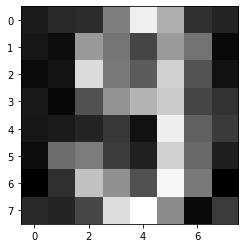

In [ ]:
plt.imshow(reshaped_images_omp[1], cmap='gray')

In [ ]:
images_train.dtype

dtype('float64')

In [ ]:
apTest.dtype

dtype('float64')

In [ ]:
yTest.dtype

dtype('float64')

In [ ]:
images_test.dtype

dtype('float64')

In [ ]:
def exp2wtf(images_train = images, images_test = images_test, sigmas = [0.5, 1, 2, 4, 8, 16, 32]):
    results_nmp = []
    results_omp = []
    m = 16
    for sigma in tqdm(sigmas):
        noisy_images_train = add_noise(images_train, sigma)

        print(f"Running for sigma = {sigma}, m = {m}")
        dictionary, _ = learn_dictionary_from_digits(noisy_images_train)
        env = OMPEnvironment(dictionary, noisy_images_train, non_zero_coeff=m)
        agent = build_agent(env)
        agent.fit(env, nb_steps=2*m*len(noisy_images_train), visualize=False, verbose=0)
        TestEnv = OMPEnvironment(dictionary, images_test, non_zero_coeff=m)
        agent.test_policy = GreedyQPolicy()
        agent.test(TestEnv, nb_episodes=len(images_test), visualize=False, verbose=0)
        apTest = np.array(TestEnv.approximated_signals)[:,0]
        yTest = np.array(TestEnv.approximated_signals)[:,1]
        avg_ssim_value = average_ssim(yTest, apTest)
        avg_mae_value = average_mae(yTest, apTest)
        avg_2norm = average_2norm(yTest, apTest)
        max_ae = max_absolute_error(yTest, apTest)
        min_ae = min_absolute_error(yTest, apTest)
        results_nmp.append([sigma, avg_ssim_value, avg_mae_value, avg_2norm, max_ae, min_ae])
        print("RL dec mean and std", np.mean(TestEnv.decisions), np.std(TestEnv.decisions))

        # Reconstruct the dataset using OMP
        reconstructed_images = reconstruct_with_OMP(dictionary, images_test, m)
        avg_ssim_value_omp = average_ssim(images_test, reconstructed_images)
        avg_mae_value_omp = average_mae(images_test, reconstructed_images)
        average_2_norm_omp = average_2norm(images_test, reconstructed_images)
        min_ae_omp = min_absolute_error(images_test, reconstructed_images)
        max_ae_omp = max_absolute_error(images_test, reconstructed_images)
        results_omp.append([sigma, avg_ssim_value_omp, avg_mae_value_omp, average_2_norm_omp, max_ae_omp, min_ae_omp])

    return np.array(results_nmp), np.array(results_omp)

In [ ]:
nmpwtf, ompwtf = exp2wtf()

  0%|          | 0/7 [00:00<?, ?it/s]

Running for sigma = 0.5, m = 16


C:\Users\Fin Amin\AppData\Roaming\Python\Python39\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


RL dec mean and var 0.0 0.0


 14%|█▍        | 1/7 [06:34<39:24, 394.06s/it]

Running for sigma = 1, m = 16


C:\Users\Fin Amin\AppData\Roaming\Python\Python39\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


RL dec mean and var 0.04790044493882091 0.21355559536917756


 29%|██▊       | 2/7 [13:21<33:29, 401.94s/it]

Running for sigma = 2, m = 16


C:\Users\Fin Amin\AppData\Roaming\Python\Python39\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


RL dec mean and var 0.0 0.0


 43%|████▎     | 3/7 [20:09<26:58, 404.72s/it]

Running for sigma = 4, m = 16


C:\Users\Fin Amin\AppData\Roaming\Python\Python39\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


RL dec mean and var 0.02196885428253615 0.14658179874748722


 57%|█████▋    | 4/7 [27:04<20:26, 408.77s/it]

Running for sigma = 8, m = 16


C:\Users\Fin Amin\AppData\Roaming\Python\Python39\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


RL dec mean and var 0.0 0.0


 71%|███████▏  | 5/7 [34:01<13:43, 411.60s/it]

Running for sigma = 16, m = 16


C:\Users\Fin Amin\AppData\Roaming\Python\Python39\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


RL dec mean and var 0.0 0.0


 86%|████████▌ | 6/7 [41:08<06:56, 417.00s/it]

Running for sigma = 32, m = 16


C:\Users\Fin Amin\AppData\Roaming\Python\Python39\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


RL dec mean and var 0.009593993325917686 0.09747793913486237


100%|██████████| 7/7 [48:21<00:00, 414.45s/it]


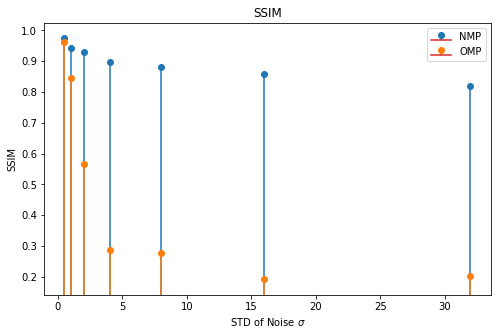

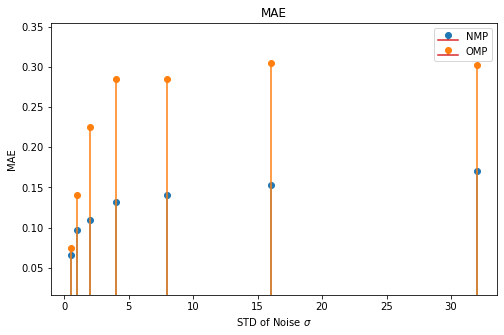

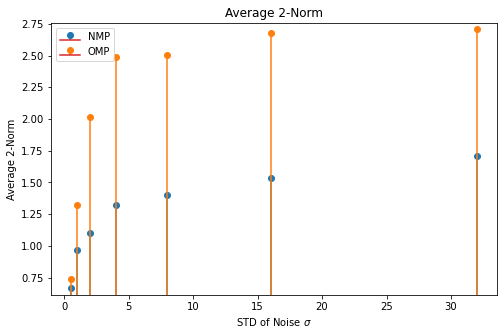

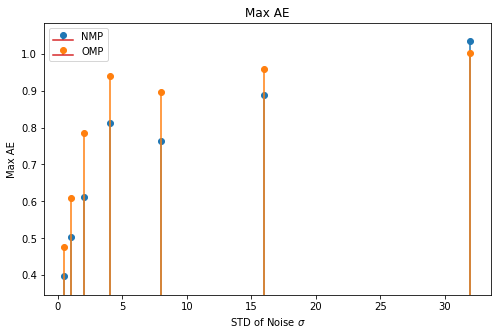

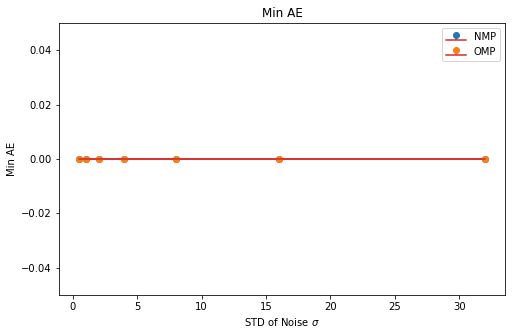

In [ ]:
# Extract metrics for plotting
metrics_nmp2 = nmpwtf[:, 1:]  # Assuming columns 2 to 5 are metrics 
metrics_omp2 = ompwtf[:, 1:]  # Assuming columns 2 to 5 are metrics 
metric_labels = ["SSIM","MAE", "Average 2-Norm","Max AE", "Min AE"]
ms = exp2_nmp[:, 0]  # Assuming column 0 is m
# Plotting each metric on a separate plot
for i in range(len(metric_labels)):
    plt.figure(figsize=(8, 5))
    plt.stem(ms, metrics_nmp2[:, i], linefmt='C0-', markerfmt='C0o', label='NMP')
    plt.stem(ms, metrics_omp2[:, i], linefmt='C1-', markerfmt='C1o', label='OMP')
    plt.ylim([np.min(np.vstack((metrics_nmp2[:, i], metrics_omp2[:, i]))) - 0.05,
              np.max(np.vstack((metrics_nmp2[:, i], metrics_omp2[:, i]))) + 0.05])
    plt.title(metric_labels[i])
    plt.xlabel("STD of Noise $\sigma$")
    plt.ylabel(metric_labels[i])
    plt.legend()
    plt.show()

# OLD

In [ ]:

def orthogonal_matching_pursuit_rl(dictionary, target_signal, sparsity, agent):
    """
    Perform Orthogonal Matching Pursuit using a Reinforcement Learning agent.

    Parameters:
    dictionary : ndarray
        The dictionary (or codebook) matrix with shape (n_features, n_components).
    target_signal : ndarray
        The signal to be approximated, with shape (n_features,).
    sparsity : int
        The desired level of sparsity (number of non-zero coefficients).
    agent : RL Agent
        The reinforcement learning agent to use for selecting atoms.

    Returns:
    approximated_signal : ndarray
        The signal approximated using selected atoms from the dictionary.
    selected_indices : list
        The indices of the atoms selected from the dictionary.
    """

    num_atoms = dictionary.shape[0]
    selected_indices = []
    approximated_signal = np.zeros((dictionary.shape[1],))
    residual = target_signal.copy()

    for _ in range(sparsity):
        observation = np.zeros(num_atoms)
        observation[selected_indices] = 1
        
        # This is where you'd get the action from the RL agent.
        # For now, we will use a placeholder for the action, which would be
        # the index with the highest correlation to the residual.
        # action = agent.forward(observation)  # This should be correctly handled.
        action = np.argmax(np.abs(np.dot(dictionary.T, residual)))

        selected_indices.append(action)
        selected_atom = dictionary[:, action]
        coefficient = np.dot(selected_atom.T, residual) / np.linalg.norm(selected_atom)**2
        approximated_signal += coefficient * selected_atom
        residual -= coefficient * selected_atom

    return approximated_signal, selected_indices

# Initialize your RL agent here.
# agent = YourRLAgent()

# Perform OMP with RL on the dataset.
sparsity = 50  # Desired sparsity level
ssim_scores = []

for image in images:  # Assuming `images` is an iterable of 1D signals.
    approximated_image, selected_indices = orthogonal_matching_pursuit_rl(dict_learner.components_.T, image, sparsity, agent)
    reconstructed_image = np.dot(dict_learner.components_[:, selected_indices], approximated_image[selected_indices])
    ssim_score = ssim(image.reshape(8, 8), reconstructed_image.reshape(8, 8), data_range=image.max() - image.min())
    ssim_scores.append(ssim_score)

# Calculate average SSIM.
average_ssim = np.mean(ssim_scores)

print("Average SSIM:", average_ssim)

In [ ]:
#I do not think this works
# Modify the OMP function to use the RL agent
def orthogonal_matching_pursuit_rl(dictionary, target_signal, sparsity, agent):
    num_atoms = dictionary.shape[1]
    selected_indices = []
    approximated_signal = np.zeros(num_atoms)
    residual = target_signal

    for _ in range(sparsity):
        observation = np.zeros(num_atoms)
        observation[selected_indices] = 1
        action = agent.forward(observation)
        correlations = np.abs(np.dot(dictionary.T, residual))
        correlations[selected_indices] = 0  # Exclude already selected indices
        # selected_index = np.argmax(correlations)
        selected_index = action
        selected_indices.append(selected_index)

        selected_atom = dictionary[:, selected_index]
        selected_atom_norm = np.linalg.norm(selected_atom)**2
        approximated_signal[selected_index] += np.dot(selected_atom.T, target_signal) / selected_atom_norm

        residual = target_signal - np.dot(dictionary[:, np.array(selected_indices)], approximated_signal[np.array(selected_indices)])

    return approximated_signal, selected_indices

# Perform OMP with RL on the dataset
sparsity = 50  # Desired sparsity level
ssim_scores = []
for image in tqdm(images):
    approximated_image, selected_indices = orthogonal_matching_pursuit_rl(dict_learner.components_.T, image, sparsity, agent)
    reconstructed_image = np.dot(images.T[:, selected_indices], approximated_image[selected_indices])
    ssim_score = ssim(image.reshape(8, 8), reconstructed_image.reshape(8, 8), data_range=16)
    ssim_scores.append(ssim_score)

# Calculate average SSIM
average_ssim = np.mean(ssim_scores)

print("Average SSIM:", average_ssim)


In [ ]:
# def reconstruct_with_OMP(dictionary, images, dict_learner):
#     """
#     Reconstruct the dataset using MiniBatchDictionaryLearning's transform method and a given dictionary.
    
#     Args:
#         dictionary: numpy array
#             The learned dictionary.
#         images: numpy array
#             The dataset to be reconstructed.
#         dict_learner: MiniBatchDictionaryLearning object
#             The trained dictionary learner.
    
#     Returns:
#         reconstructed: numpy array
#             The reconstructed dataset.
#     """
#     # Get the sparse representation of the images using the dictionary learner
#     coefficients = dict_learner.transform(images)

#     # print(coefficients.shape)
#     # dictionary = dictionary
#     # print(coefficients[0])
#     # assert(False)
    
#     # Reconstruct the images from the coefficients and the dictionary
#     reconstructed = np.dot(coefficients, dictionary)
#     return reconstructed


In [ ]:

def orthogonal_matching_pursuit(dictionary, target_signal, sparsity):
    num_atoms = dictionary.shape[1]
    selected_indices = []
    approximated_signal = np.zeros(num_atoms)
    residual = target_signal

    for _ in range(sparsity):
        correlations = np.abs(np.dot(dictionary.T, residual))
        correlations[selected_indices] = 0  # Exclude already selected indices
        selected_index = np.argmax(correlations)
        selected_indices.append(selected_index)

        selected_atom = dictionary[:, selected_index]
        selected_atom_norm = np.linalg.norm(selected_atom)**2
        approximated_signal[selected_index] += np.dot(selected_atom.T, target_signal) / selected_atom_norm

        residual = target_signal - np.dot(dictionary[:, np.array(selected_indices)], approximated_signal[np.array(selected_indices)])

    return approximated_signal, selected_indices


In [ ]:


# Load MNIST dataset
digits = load_digits()  # Replace with appropriate code to load MNIST dataset
images = digits.data


In [ ]:
images.shape

In [ ]:
plt.imshow(images[6].reshape(8,8))

In [ ]:
dict_learner = DictionaryLearning(
    n_components=64,
    fit_algorithm='cd',
    transform_algorithm= 'omp', 
    random_state=0) 


In [ ]:
dict_learner.fit(images[0:100])

In [ ]:
ssim_scores = []

for image in tqdm(images):
    reconstructed_image = dict_learner.transform(image.reshape(1,-1)) 
    image = image.reshape(8,8) 
    reconstructed_image = reconstructed_image.reshape(8,8) 
    ssim_score = ssim(image, reconstructed_image, data_range=reconstructed_image.max() - reconstructed_image.min())
    ssim_scores.append(ssim_score)

# Calculate average SSIM
average_ssim = np.mean(ssim_scores)

print("Average SSIM:", average_ssim)

In [ ]:
plt.imshow(reconstructed_image)

In [ ]:

# OMP parameters
sparsity = 50  # Desired sparsity level

# Perform OMP on each image
ssim_scores = []
for image in tqdm(images):
    approximated_image, selected_indices = orthogonal_matching_pursuit(dict_learner.components_.T, image, sparsity)
    reconstructed_image = np.dot(images.T[:, selected_indices], approximated_image[selected_indices])
    reconstructed_image = reconstructed_image.reshape(8,8) 
    image = image.reshape(8,8) 
    ssim_score = ssim(image, reconstructed_image, data_range=reconstructed_image.max() - reconstructed_image.min())
    ssim_scores.append(ssim_score)

# Calculate average SSIM
average_ssim = np.mean(ssim_scores)

print("Average SSIM:", average_ssim)


In [ ]:
images.shape

In [ ]:
labels_reshaped

In [ ]:
predicted_labels